# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
plt.style.use('ggplot')

# Data preprocessing

### Reading to a DataFrame, Drop irrelevant colums and Split to train and valid sets

In [2]:
# Read data and choose target variable
X = pd.read_csv('train_data.csv')
y = X['PRICE']

In [3]:
# Dropping irrelevant features and target variable
X.drop(['ADDRESS', 'SUBURB', 'NEAREST_STN', 'POSTCODE', 'NEAREST_SCH', 'PRICE'], axis=1, inplace=True)

In [4]:
# Splitting data into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [5]:
for col in X_train.columns:
    print(col, X_train[col].dtype)

BEDROOMS int64
BATHROOMS int64
GARAGE float64
LAND_AREA int64
FLOOR_AREA int64
BUILD_YEAR float64
CBD_DIST int64
NEAREST_STN_DIST int64
DATE_SOLD object
LATITUDE float64
LONGITUDE float64
NEAREST_SCH_DIST float64
NEAREST_SCH_RANK float64


In [6]:
X_train.head(3)

,BEDROOMS,BATHROOMS,GARAGE,LAND_AREA,FLOOR_AREA,BUILD_YEAR,CBD_DIST,NEAREST_STN_DIST,DATE_SOLD,LATITUDE,LONGITUDE,NEAREST_SCH_DIST,NEAREST_SCH_RANK
13766,4,2,2.0,727,247,2000.0,19200,6900,06-2016\r,-32.10871,115.77436,2.882725,NaN
10608,3,1,3.0,1012,180,1954.0,14000,342,03-2009\r,-31.89425,115.99063,0.615433,130.0
21357,4,2,5.0,603,189,1997.0,20700,6000,04-2019\r,-32.13019,115.79457,2.946685,NaN


### 'DATE_SOLD' column handling

Ideas on what to do with the date:
1) Extract only the years and use OrdinalEncoder.
2) Convert the dates to the number of seconds/minutes/hours/days since 1970-01-01. (consider some normalization but I believe that in ensamble methods such as XGBoost it is not required)

In [7]:
min(pd.to_datetime(X_train['DATE_SOLD'])) # It's later than 1970-01-01 so we're good

Timestamp('1988-04-01 00:00:00')

In [8]:
# Approach 2

# Convert to integers
X_train['DATE_SOLD'] = pd.to_datetime(X_train['DATE_SOLD']).astype(int) // 10**9 # // 10**9 because astype(int) returns nanoseconds from 1970-01-01
X_valid['DATE_SOLD'] = pd.to_datetime(X_valid['DATE_SOLD']).astype(int) // 10**9

# Perform normalization
# scaler = MinMaxScaler()
# scaled_date_train = scaler.fit_transform(X_train[['DATE_SOLD']])
# scaled_date_valid = scaler.transform(X_valid[['DATE_SOLD']])
# X_train['DATE_SOLD'] = scaled_date_train
# X_valid['DATE_SOLD'] = scaled_date_valid

In our dataframe there isn't any categorical variables left therefore we can go to the next step

### NaN values handling

In [9]:
cols_with_missing = [col for col in X_train.columns
                     if X_train[col].isnull().any()]
for col in cols_with_missing:
    print(col, X_train[col].isnull().sum())

GARAGE 1357
BUILD_YEAR 1729
NEAREST_SCH_RANK 6131


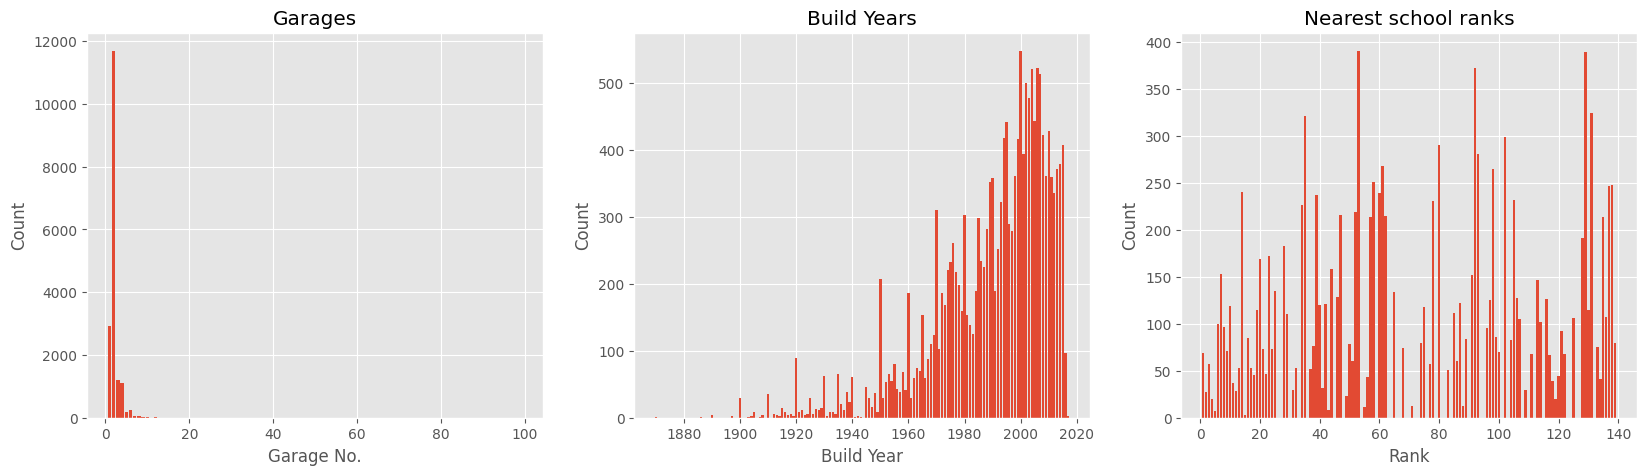

In [10]:
garages = X_train['GARAGE'].value_counts().sort_index()
garages.index = garages.index.astype('int')

build_yrs = X_train['BUILD_YEAR'].value_counts().sort_index()
build_yrs.index = build_yrs.index.astype('int')

sch_ranks = X_train['NEAREST_SCH_RANK'].value_counts().sort_index()
sch_ranks.indes = sch_ranks.index.astype('int')

fig, ax = plt.subplots(1,3, figsize=(20,5))
ax[0].bar(garages.index, garages.values)
ax[0].set_xlabel('Garage No.')
ax[0].set_ylabel('Count')
ax[0].set_title('Garages')

ax[1].bar(build_yrs.index, build_yrs.values)
ax[1].set_xlabel('Build Year')
ax[1].set_ylabel('Count')
ax[1].set_title('Build Years')

ax[2].bar(sch_ranks.index, sch_ranks.values)
ax[2].set_xlabel('Rank')
ax[2].set_ylabel('Count')
ax[2].set_title('Nearest school ranks')

plt.show()

Potential approaches:
1) Drop rows with NaN values
2) Impute mean, median or most_frequent value from column

In [11]:
# Approach 2:

# For build year: median
# For nearest school rank and garage: most_frequent

# create preprocessor that will be later add to a pipeline

most_freq_cols = ['GARAGE', 'NEAREST_SCH_RANK']
median_cols = ['BUILD_YEAR']

most_freq_imputer = SimpleImputer(strategy='most_frequent')
median_imputer = SimpleImputer(strategy='median')

preprocessor = ColumnTransformer(
    transformers=[
        ('most_freq', most_freq_imputer, most_freq_cols),
        ('median', median_imputer, median_cols)
    ],
    remainder='passthrough')

### Correlation between features

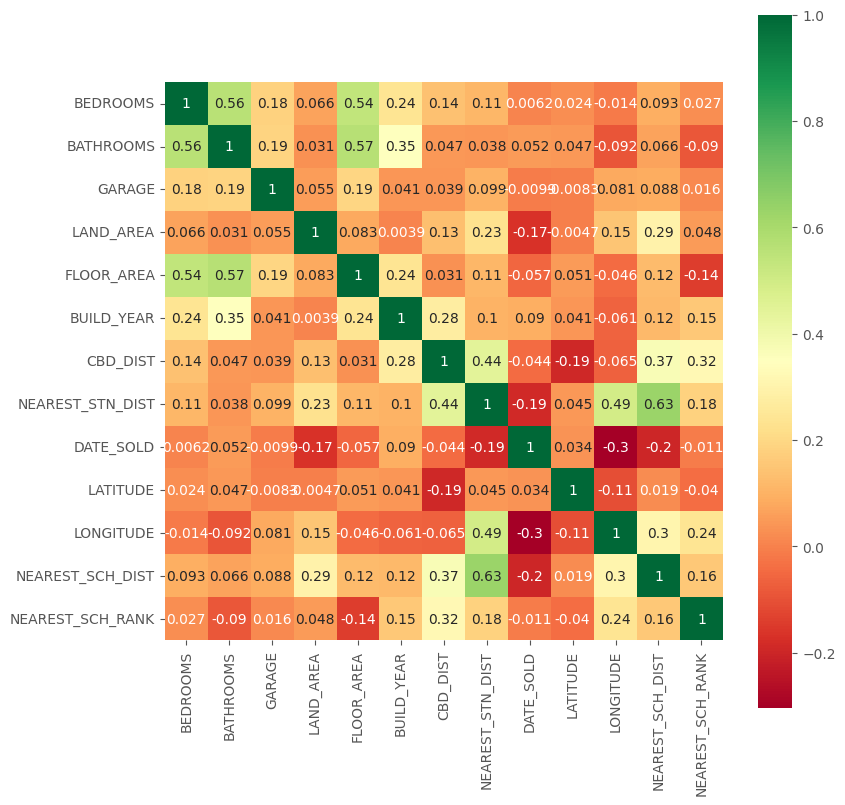

In [12]:
plt.figure(figsize=(9,9))
sns.heatmap(X_train.corr(), square=True, cmap='RdYlGn', annot=True)
plt.show()

# Building pipeline with regressor

In [13]:
# just default regressor with no fine-tuning at all
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror'))
])

pipeline.fit(X_train, y_train)

# Imputation for validation set ??
# X_valid = pd.DataFrame(pipeline.named_steps['preprocessor'].fit_transform(X_valid), columns=X_valid.columns)

y_pred = pipeline.predict(X_valid)
mae = mean_absolute_error(y_pred, y_valid)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 88798.26810334722


In [14]:
y.mean()

636890.3200033818